# KAN PDE Solver

We will use the example provided in the official implementation of the KAN paper.
Install the library with

```pip install pykan```

**2D Poisson PDE**

We will take [Example-6](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example/Example_6_PDE_interpretation.ipynb) provided in the PyKAN repo.

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.


In [18]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dim = 2
np_i = 30 # number of interior points (along each dimension)
np_b = 30 # number of boundary points (along each dimension)
ranges = [-1, 1]

model = KAN(width=[2,2,2,1,1], grid=5, k=3, seed=1, device=device)

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]])

# interior
sampling_mode = 'random' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1
    
x_i = x_i.to(device)

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_b = x_b.to(device)

steps = 20
alpha = 0.01
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=0.1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.cpu().detach().numpy()))

train()

cpu
checkpoint directory created: ./model
saving model version 0.0


pde loss: 4.65e+01 | bc loss: 5.23e-02 | l2: 1.43e-01 : 100%|███████| 20/20 [00:34<00:00,  1.73s/it]


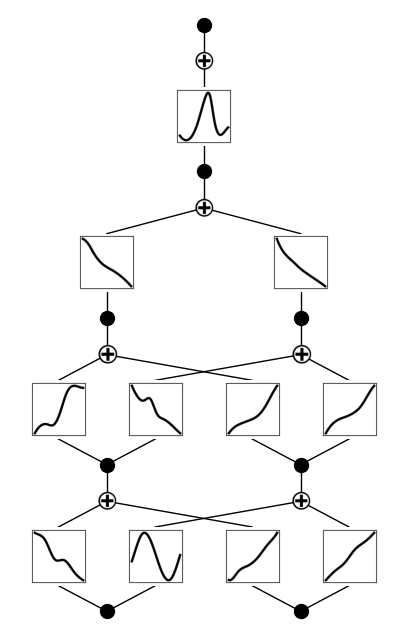

In [19]:
model.plot(beta=10)

In [20]:
lib = ['x','sin','log','exp']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9569580554962158, c=1
fixing (0,0,1) with sin, r2=0.9994773268699646, c=2
fixing (0,1,0) with x, r2=0.9826741814613342, c=1
fixing (0,1,1) with x, r2=0.9958211779594421, c=1
fixing (1,0,0) with x, r2=0.8470919728279114, c=1
fixing (1,0,1) with x, r2=0.9101454019546509, c=1
fixing (1,1,0) with x, r2=0.8957751989364624, c=1
fixing (1,1,1) with x, r2=0.924821674823761, c=1
fixing (2,0,0) with x, r2=0.9645843505859375, c=1
fixing (2,1,0) with x, r2=0.9815171360969543, c=1
fixing (3,0,0) with x, r2=0.06022500991821289, c=1
saving model version 0.1


In [21]:
formula = model.symbolic_formula()
print(formula)

([0.000678440416089527*x_1 - 0.0932934275961874*x_2 - 0.0355230525977442*sin(3.26248002052307*x_1 - 3.20023989677429) + 0.131764609939269], [x_1, x_2])


It is not quite there. 
TBD: Let us plot the solution (and see how it differs)